In [77]:
%pip install yfinance matplotlib pandas scikit-learn plotly requests keras 

Note: you may need to restart the kernel to use updated packages.


In [78]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()
%matplotlib inline

In [79]:
tahmingunu = 7
tariharalıgı = 4000
parite ="BTC-USD"

In [80]:
d1 = today.strftime("%Y-%m-%d")# strftime : string formatı tarih formatına çevirir
end_date = d1
d2 = date.today() - timedelta(days=tariharalıgı)# tarih aralığının ayarlandığı kısmı
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

In [81]:
data = yf.download(parite,
                   start =start_date,
                   end =end_date,
                   progress=False)

data["Date"] = data.index
hist =  data[["Date","Open","High","Low","Close","Adj Close","Volume"]]
#hist.reset_index(inplace=True, drop=True )
hist =hist.set_index("Date")
hist.index = pd.to_datetime(hist.index)

In [82]:

target_cols = ['Open', 'Close' ,'Low' ,'High'] #hedef kolonu

In [83]:
hist.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800


In [84]:
hist.tail(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-31,42946.25,43717.40625,42298.945312,42582.605469,42582.605469,24673628793


In [85]:
test_size = tahmingunu
def train_test_split(df, test_size):
    split_row = len(df) - test_size
    train_data = df.iloc[:split_row, :]
    test_data = df.iloc[split_row:, :]
    return train_data, test_data

In [86]:
train, test = train_test_split(hist, test_size) # train_data ve test_data'yi  train ve test olarak ayırıyoruz

In [87]:
train.tail(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-24,39877.59375,40483.785156,39508.796875,40077.074219,40077.074219,22359526178


In [88]:
test.tail(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-31,42946.25,43717.40625,42298.945312,42582.605469,42582.605469,24673628793


In [89]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel(parite, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

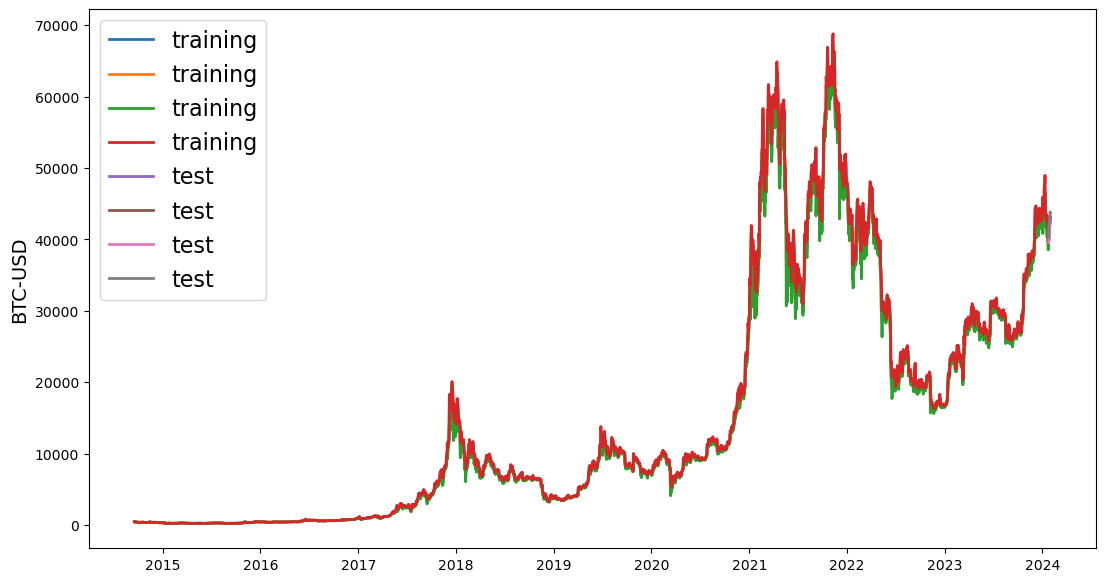

In [90]:
line_plot(train[target_cols], test[target_cols], 'training', 'test', title='')

In [91]:
# candlestick train and test data
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=train.index,
                                    open=train['Open'],
                                    high=train['High'],
                                    low=train['Low'],
                                    close=train['Close'],
                                    name='training')])
fig.update_layout(title=parite + ' candlestick' ,
                  xaxis_rangeslider_visible=True,

                  )



fig.add_candlestick( x=test.index ,
                    open=test['Open'],
                    high=test['High'],
                    low=test['Low'],
                    close=test['Close'],
                    name='test',
                    increasing_line_color='#00ff00',
                    decreasing_line_color='#ff0000')
fig.update_layout(autosize=True, width=1200, height=800,
                template='plotly_white',)

fig.show()

In [92]:
def normalize_zero_base(df): #verileri 0 baslangıcında normalize ediyoruz
    return df / df.iloc[0] - 1

def normalize_min_max(df): #verileri min max aralığında normalize ediyoruz
    return (df - df.min()) / (df.max() - df.min())


In [93]:
def extract_window_data(df, window_len=30, zero_base=True): #verileri windowleniyoruz
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalize_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [94]:
def prepare_data(df, target_col, window_len=30, zero_base=True, test_size=0.2): #verileri hazırlar
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [95]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, )
    return model

In [96]:
window_len = 60
zero_base = True
lstm_neurons = 10
epochs = 10 # işlemi tekrar sayısı
batch_size = 64 # ideal olarak 64
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activator = 'linear'
output_size=len(target_cols) #cıktı sutunları

In [97]:
train, test , X_train, X_test , y_train, y_test = prepare_data(hist, target_cols, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [98]:
# train verilerinin uzunluğu
print(X_train.shape)

(3357, 60, 6)


In [99]:
model = build_lstm_model(X_train, output_size=output_size, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)

In [100]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                680       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
 activation_3 (Activation)   (None, 4)                 0         
                                                                 
Total params: 724 (2.83 KB)
Trainable params: 724 (2.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
50/53 [===========================>..] - ETA: 0s - loss: 0.2530

ValueError: Expected input data to be non-empty.

In [ ]:
targets = test[target_cols][window_len:]
preds = model.predict(X_test).squeeze()

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
MSE = mean_squared_error(preds, y_test)
MAE = mean_absolute_error(preds, y_test)
R2 = r2_score(preds, y_test)
print(f'MSE: {MSE}')
print(f'MAE: {MAE}')
print(f'R2: {R2}')

In [ ]:
preds = test[target_cols].values[:-window_len]*(preds+1)
preds = pd.DataFrame(preds, index=targets.index, columns=target_cols)
preds.tail()

In [ ]:
import plotly.graph_objects as go
fig.add_candlestick(x=preds.index,
                    open=preds["Open"],
                    high=preds["High"],
                    low=preds["Low"],
                    close=preds["Close"],
                    name="Preds",)

In [ ]:
#todos :

#gerçek zamanlı veri analizi için :
#adımlar :
#1- verileri çek
#2- verileri hazırla
#3- modeli yükle
#4- modeli kullanarak tahmin yap
#5- tahminleri görselleştir
#6- tahminleri kaydet